In [1]:
import matplotlib.pyplot as plt

import torch
import torch.distributions as dist
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
from src.loss import snn_loss

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def generate_data(n: int, sd: float = 1):
    """n: size of each Gaussian blob."""
    z_s00 = torch.randn(n, 2) * sd
    z_s10 = torch.randn(n, 2) * sd + 3
    z_s0 = torch.cat([z_s00, z_s10], dim=0)

    z_s01 = torch.randn(n, 2) * sd + torch.tensor([[-5, 5]])
    z_s11 = torch.randn(n, 2) * sd + torch.tensor([[-1, 7]])
    z_s1 = torch.cat([z_s01, z_s11], dim=0)

    # z_s02 = torch.randn(n, 2) * sd + torch.tensor([[-5, -5]])
    # z_s12 = torch.randn(n, 2) * sd + torch.tensor([[-1, -7]])
    # z_s2 = torch.cat([z_s02, z_s12], dim=0)

    # z_s = torch.cat([z_s0, z_s1, z_s2], dim=0)
    z_s = torch.cat([z_s0, z_s1], dim=0)


    # content_label = torch.tensor([0] * 2 * n + [1] * 2 * n + [2] * 2 * n)
    # style_label = torch.tensor(([0] * n + [1] * n) * 3)
    content_label = torch.tensor([0] * 2 * n + [1] * 2 * n)
    style_label = torch.tensor(([0] * n + [1] * n) * 2)

    return z_s, content_label, style_label

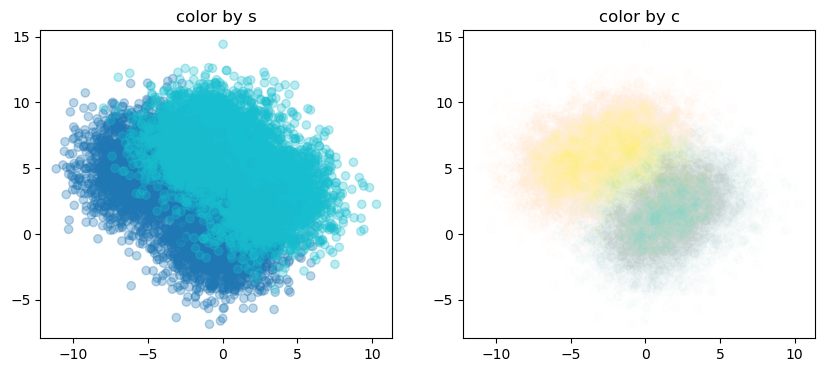

In [4]:
x, content_label, style_label = generate_data(3000, 2) # six blobs -> 6 * 3k
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(x[:, 0], x[:, 1], c=style_label, cmap="tab10", alpha=0.3)
axs[0].set_title("color by s")
axs[1].scatter(x[:, 0], x[:, 1], c=content_label, cmap="Set3",  alpha=0.01)
axs[1].set_title("color by c")
plt.show()

In [5]:
data = TensorDataset(
    x, content_label, style_label
)
dataloader = DataLoader(data, batch_size=128, shuffle=True)

In [6]:
class CLEAREncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.enc = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 4)
        )
        self.c = nn.Linear(4, z_dim)
        self.s = nn.Linear(4, z_dim)
        self.dec = nn.Sequential(
            nn.Linear(z_dim + z_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )

    def forward(self, x):
        h = self.enc(x)
        c, s = self.c(h), self.s(h)
        xhat = self.dec(torch.cat([c, s], dim=1))
        return xhat, (c, s)

100%|██████████| 94/94 [00:00<00:00, 120.99batch/s, anticontrast=0.682, contrast=0.13, loss=11.3]  


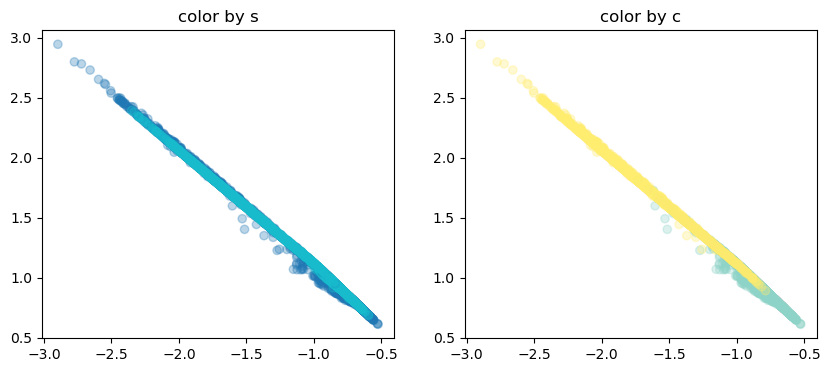

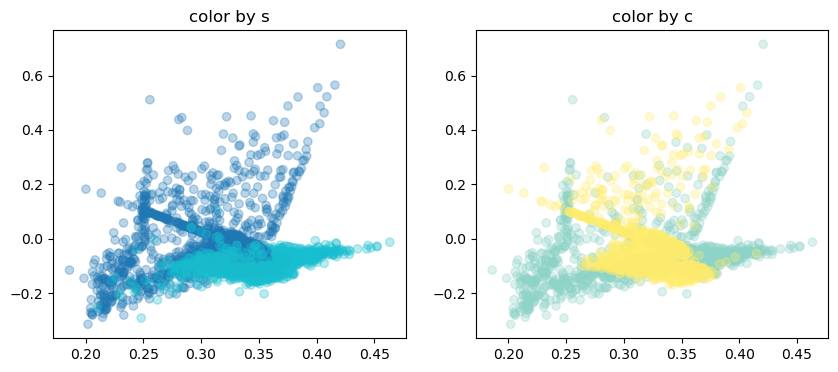

100%|██████████| 94/94 [00:00<00:00, 139.28batch/s, anticontrast=0.696, contrast=0.169, loss=0.109]  


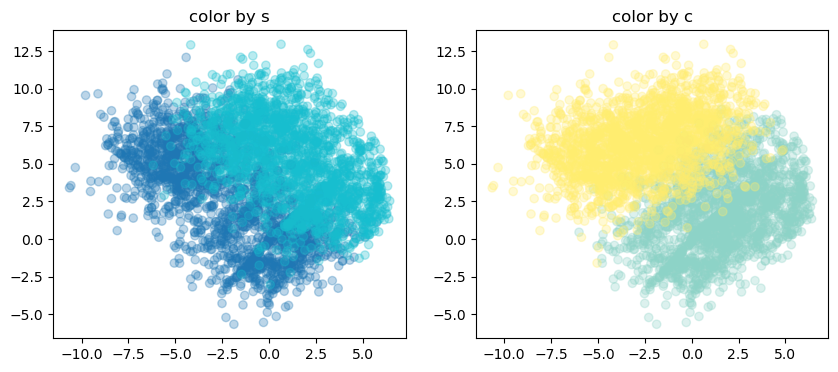

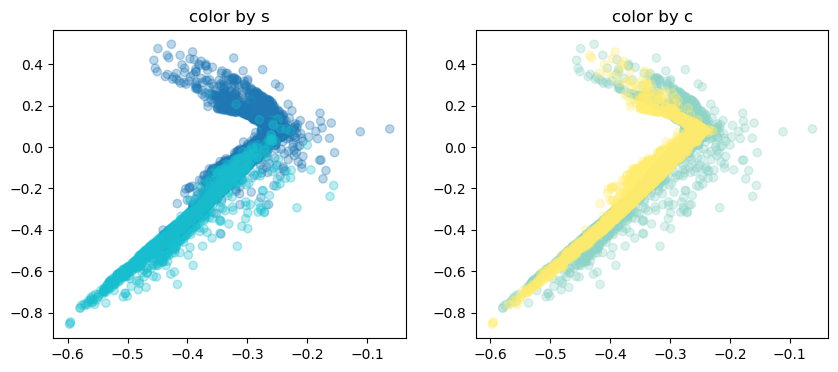

100%|██████████| 94/94 [00:00<00:00, 132.80batch/s, anticontrast=0.679, contrast=0.136, loss=0.0254] 


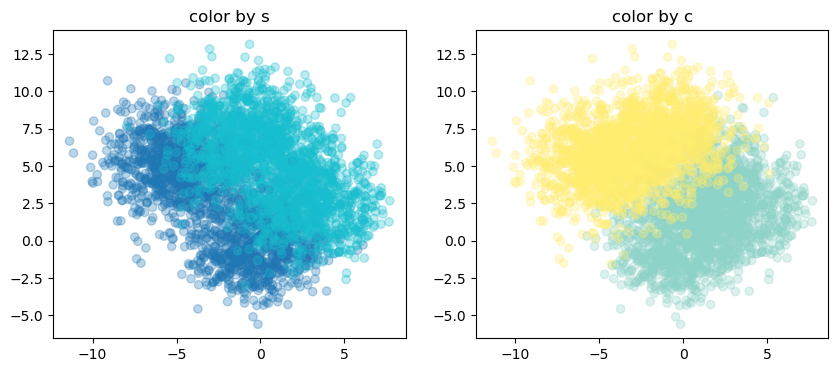

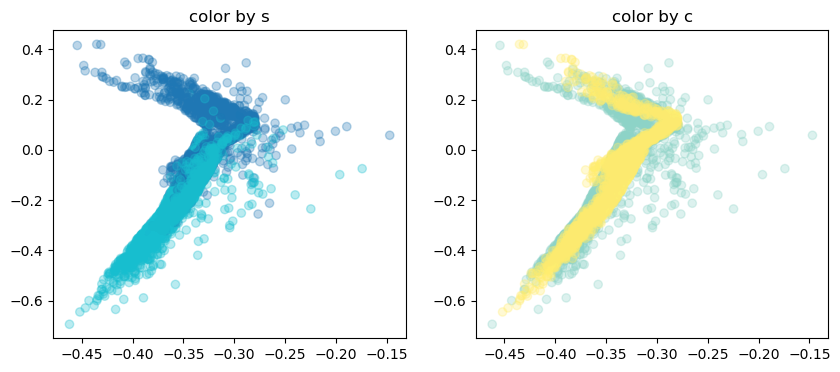

100%|██████████| 94/94 [00:00<00:00, 145.63batch/s, anticontrast=0.704, contrast=0.167, loss=0.0161] 


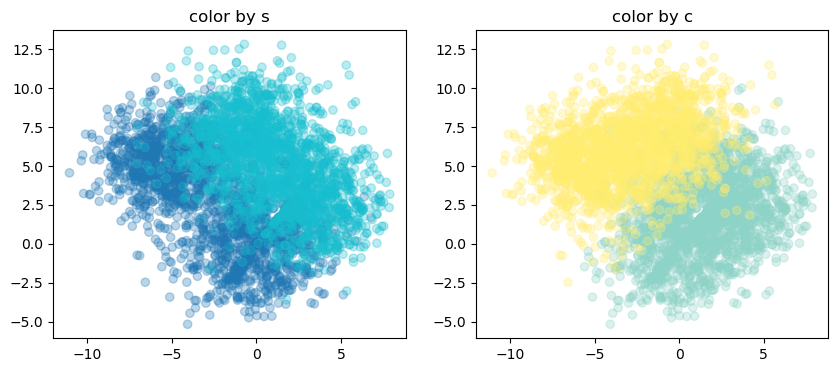

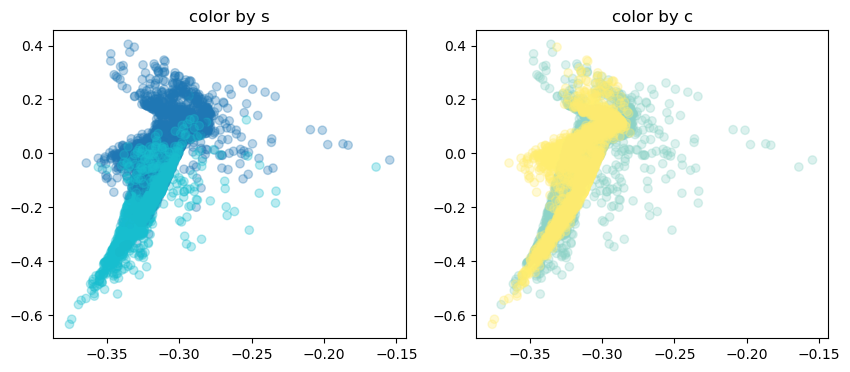

100%|██████████| 94/94 [00:00<00:00, 138.05batch/s, anticontrast=0.683, contrast=0.149, loss=0.0619] 


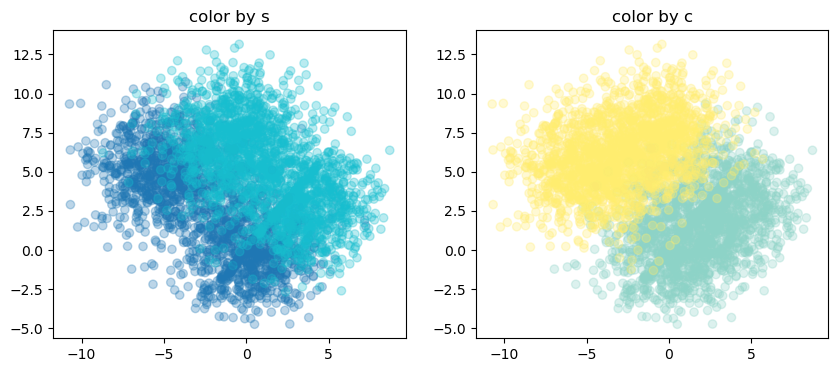

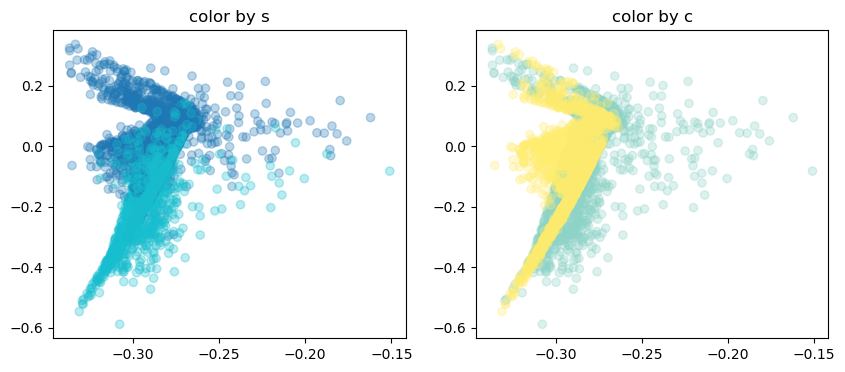

100%|██████████| 94/94 [00:00<00:00, 140.33batch/s, anticontrast=0.683, contrast=0.202, loss=0.0232] 


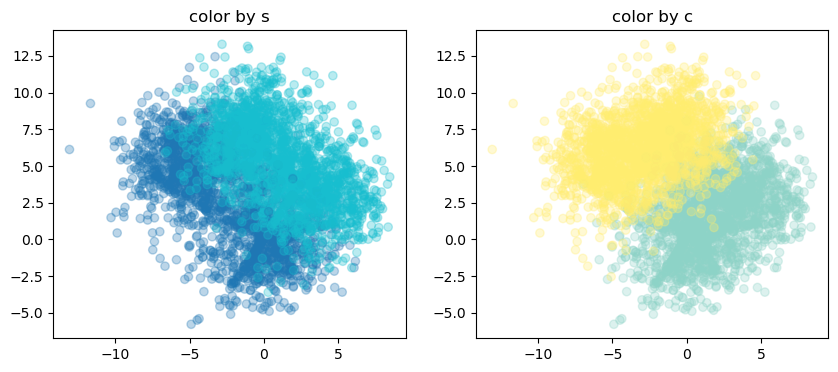

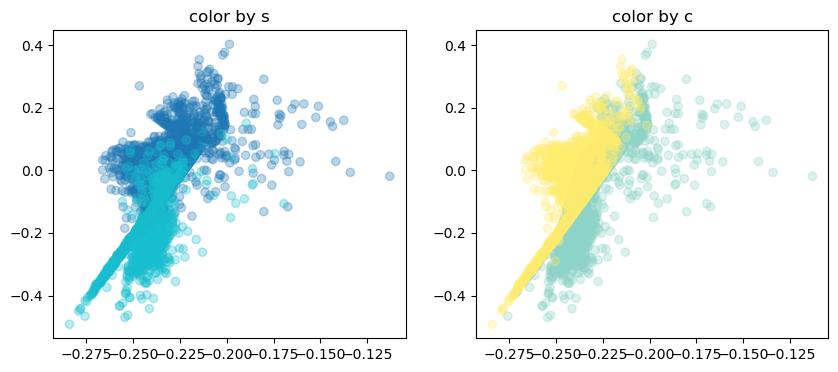

100%|██████████| 94/94 [00:00<00:00, 151.19batch/s, anticontrast=0.686, contrast=0.205, loss=0.0298] 


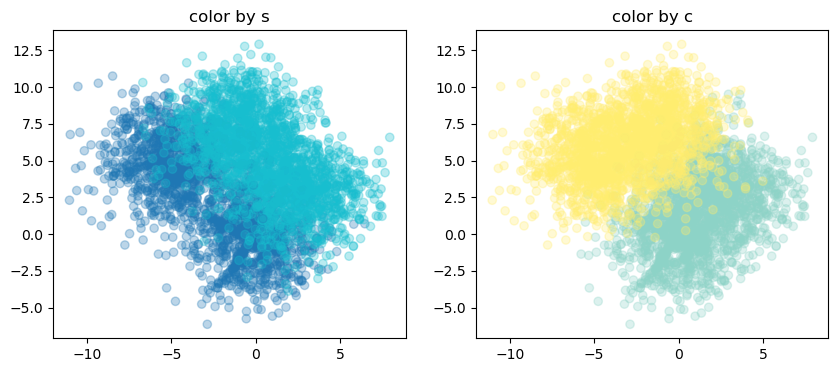

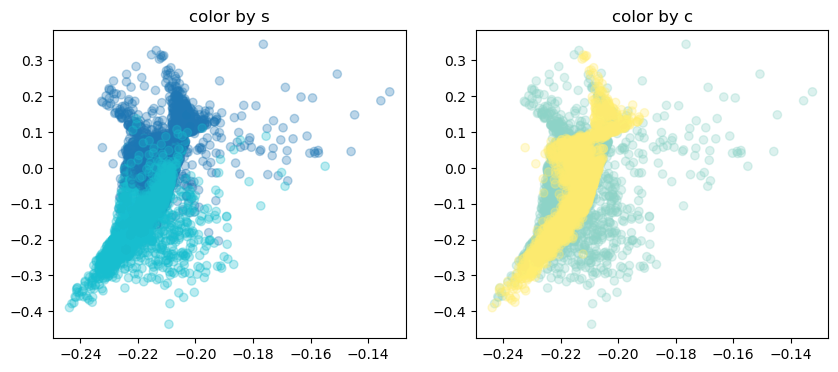

100%|██████████| 94/94 [00:00<00:00, 139.27batch/s, anticontrast=0.718, contrast=0.114, loss=0.0399]  


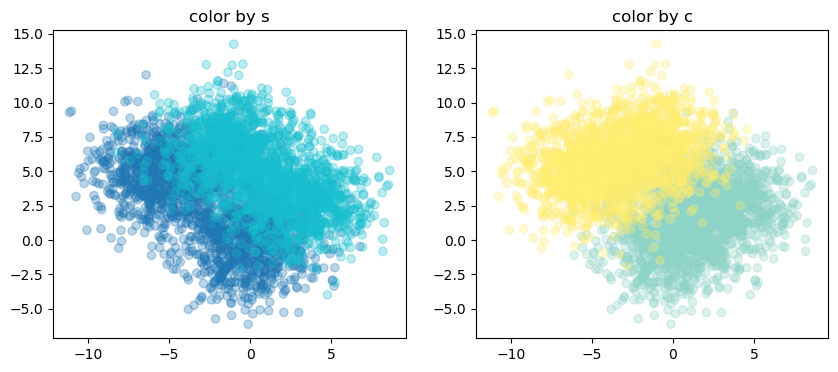

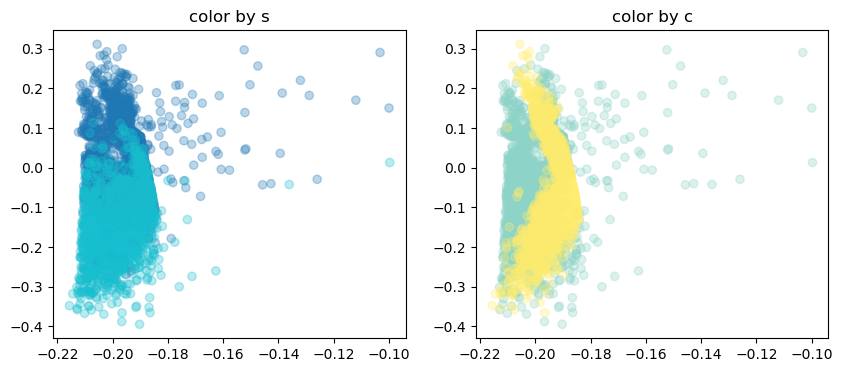

100%|██████████| 94/94 [00:00<00:00, 134.33batch/s, anticontrast=0.687, contrast=0.131, loss=0.0399] 


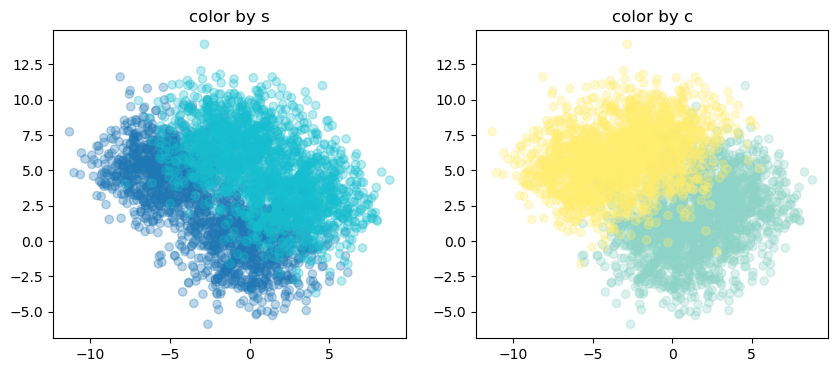

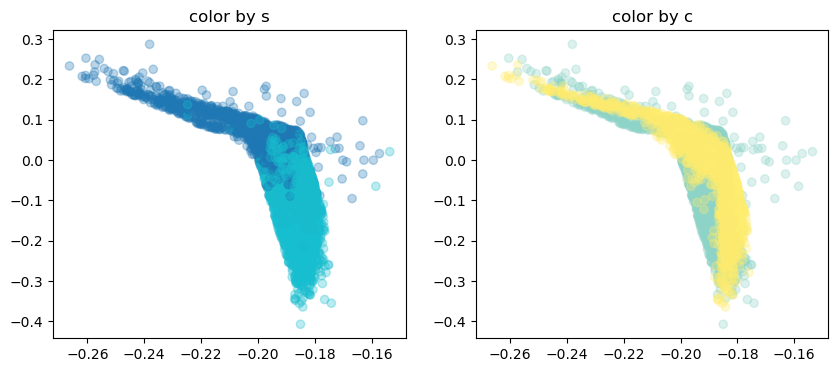

In [9]:
model = CLEAREncoder(z_dim=2).to(device)
optimizer = Adam(model.parameters(), lr=2e-3)
contrast_losses, anticontrast_losses = [], []
plot_data = []
for i in range(81):
    verbose = i % 10 == 0
    with tqdm(dataloader, unit="batch", disable=not verbose) as bar:
        for batch in bar:
            optimizer.zero_grad()
            x, y, _ = batch
            x, y = x.to(device), y.to(device)
            xhat, (c, s) = model(x)
            _recon = nn.functional.mse_loss(xhat, x)
            _contrast = snn_loss(c, y, temperature=0.1)
            _anticontrast = snn_loss(s, y, temperature=0.1, flip=True)
            (_recon + 50 * _contrast + 50 *_anticontrast).backward()
            optimizer.step()
            bar.set_postfix(loss=float(_recon), contrast=float(_contrast), anticontrast=float(_anticontrast))
            contrast_losses.append(_contrast.item())
            anticontrast_losses.append(_anticontrast.item())
    if verbose:
        with torch.no_grad():
            x_s, content_label, style_label = generate_data(1000, 2)
            xhat, (c, s) = model(x_s.to(device))
            xhat, c, s = xhat.detach().cpu(), c.detach().cpu(), s.detach().cpu()
            plot_data.append(
                {
                    "c": c,
                    "s": s,
                    "style_label": style_label,
                    "content_label": content_label,
                }
            )
            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(xhat[:, 0], xhat[:, 1], c=style_label, cmap="tab10", alpha=0.3)
            axs[0].set_title("color by s")
            axs[1].scatter(xhat[:, 0], xhat[:, 1], c=content_label, cmap="Set3",  alpha=0.3)
            axs[1].set_title("color by c")
            plt.show()

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].scatter(
                s[:, 0],
                s[:, 1],
                c=style_label,
                cmap="tab10",
                alpha=0.3,
            )
            axs[0].set_title("color by s")
            axs[1].scatter(
                s[:, 0],
                s[:, 1],
                c=content_label,
                cmap="Set3",
                alpha=0.3,
            )
            axs[1].set_title("color by c")
            plt.show()

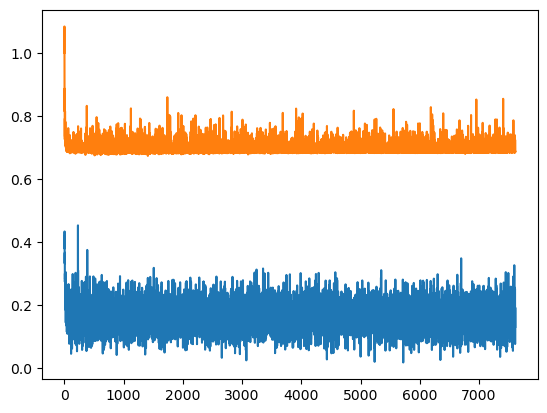

In [10]:
plt.plot(contrast_losses)
plt.plot(anticontrast_losses)